<a href="https://colab.research.google.com/github/jselvarathinam/cse5334/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uploading Images of Motorbikes/Schooners/Airplanes


In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
#Importing Necessary packages
import os
import tensorflow as tf
import random
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import zipfile
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, shutil, math, cv2, json, random
from tqdm import tqdm
from keras.layers import *
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
"""
The following four cells make a kaggle directory in this workspace and download the caltech101 dataset into it.
I learned how to do this from the following youtube tutorial: https://www.youtube.com/watch?v=yEXkEUqK52Q. I think 
this code is fairly common but I wanted to include a reference just in case.
"""
! mkdir ~/.kaggle

In [5]:
! cp /content/drive/MyDrive/ColabNotebooks/kaggle.json ~/.kaggle/kaggle.json

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d maricinnamon/caltech101-airplanes-motorbikes-schooners

 96% 14.0M/14.5M [00:00<00:00, 31.4MB/s]
100% 14.5M/14.5M [00:00<00:00, 31.0MB/s]


In [ ]:
! unzip caltech101-airplanes-motorbikes-schooners.zip

# Splitting Data into Train/Test/Validation

In [13]:
'''
This code in this cell is from https://www.kaggle.com/code/jiaowoguanren/airplanes-motorbikes-schooners-tf-efficientnet 
I used it to create a train/test/validate split for my data. (It also helped me in the next cell to understand I needed to use the 
".flow_from_dataframe" when generating batches of images and labels for training, testing and validating the neural net). 
'''
sdir = '/content/caltech101_classification'

#Defining function that creates training, testing, and validation dataframes
def make_dataframes(sdir):
    bad_images = []
    good_ext = ['jpg', 'jpeg', 'png', 'tiff']
    filepaths = []
    labels = []
    classes = sorted(os.listdir(sdir))
    for klass in classes:
        classpath = os.path.join(sdir, klass)
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index + 1:]
            if ext in good_ext:
                try:
                    img = cv2.imread(fpath)
                    shape = img.shape
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
                    print('defective image file: ', fpath)
            else:
                bad_images.append(fpath)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)

    train_df, dummy_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123,
                                         stratify=dummy_df['labels'])
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)
    sample_df = train_df.sample(n=50, replace=False)

    ht = 0
    wt = 0
    count = 0
    
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            wt += w
            ht += h
            count += 1
        except:
            pass
    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print('number of classes in processed dataset= ', class_count)
    counts = list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts),
          '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df, classes, class_count

#Create training, testing, and validation dataframes
train_df, test_df, valid_df, classes, class_count = make_dataframes(sdir)

schooner               : 100%|████████████████████████████████████████████| 63/63 [00:00<00:00, 1221.87file/s]


number of classes in processed dataset=  3
the maximum files in any class in train_df is  640   the minimum files in any class in train_df is  50
train_df length:  1328   test_df length:  167   valid_df length:  166
average image height=  167   average image width=  336  aspect ratio h/w=  0.49702380952380953


In [17]:
"""
The code in this cell and the next 2 cells is loosely based on the code in the following tutorial: 
https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%208%20-%20Lesson%202%20-%20Notebook%20(RockPaperScissors).ipynb#scrollTo=ZABJp7T3VLCU
I say loosely based because while I learned the essence of how to set up, compile and fit the model from this tutorial it would not have worked for the problem I am trying to solve,
I had to learn what all the code, parameters and hyperparamters meant from documentation and tutorials (that I've linked in my blog post) and then write code that would actually work for 
my particular problem. Therefore these next few cells are where most of my unique contributions are. 
"""
#Rescaling images
train_datagen = ImageDataGenerator(rescale= 1.0/255)
test_datagen = ImageDataGenerator(rescale= 1.0/255)
valid_datagen = ImageDataGenerator(rescale= 1.0/255) 

#Generating batches of images for training, validation, and testing along with their labels to be fed into the neural net
#Read documentation on .flow_from_dataframe() from tensorflow website: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe
train_data = train_datagen.flow_from_dataframe(train_df, x_col = "filepaths", y_col = "labels", batch_size =50, class_mode= "categorical", target_size = (224,224))
test_data = test_datagen.flow_from_dataframe(test_df, x_col = "filepaths", y_col = "labels", batch_size =50, class_mode= "categorical", target_size = (224,224))
valid_data = valid_datagen.flow_from_dataframe(valid_df, x_col = "filepaths", y_col = "labels", batch_size =50, class_mode= "categorical", target_size = (224,224))

Found 1328 validated image filenames belonging to 3 classes.
Found 167 validated image filenames belonging to 3 classes.
Found 166 validated image filenames belonging to 3 classes.


# Building and Compiling and Running the Neural Net



In [103]:
#Building the model
model = tf.keras.models.Sequential([
    
    #First convolution Layer
    tf.keras.layers.Conv2D(16, (3,3), activation= "relu", input_shape= (224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    #Second convolution layer
    tf.keras.layers.Conv2D(32, (3,3), activation= "relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    #Flattening to feed into DNN
    tf.keras.layers.Flatten(),

    #Hidden Layer with 512 neurons
    tf.keras.layers.Dense(512, activation= 'relu'),

    #Output layer
    tf.keras.layers.Dense(3, activation= 'softmax')

    ])

model.compile(loss= "mean_squared_error", optimizer= RMSprop(lr=0.001), metrics = ["acc"])


In [104]:
#Fitting the model
history = model.fit(train_data, 
                    epochs = 20, 
                    steps_per_epoch = 5, 
                    validation_data = valid_data, 
                    validation_steps = 2)

Epoch 1/20
5/5 [==============================] - 9s 2s/step - loss: 0.2638 - acc: 0.5360 - val_loss: 0.3400 - val_acc: 0.4900
Epoch 2/20
5/5 [==============================] - 8s 2s/step - loss: 0.3680 - acc: 0.4480 - val_loss: 0.3533 - val_acc: 0.4700
Epoch 3/20
5/5 [==============================] - 8s 2s/step - loss: 0.3280 - acc: 0.5080 - val_loss: 0.3333 - val_acc: 0.5000
Epoch 4/20
5/5 [==============================] - 8s 2s/step - loss: 0.3787 - acc: 0.4320 - val_loss: 0.3533 - val_acc: 0.4700
Epoch 5/20
5/5 [==============================] - 7s 2s/step - loss: 0.3713 - acc: 0.4430 - val_loss: 0.3000 - val_acc: 0.5500
Epoch 6/20
5/5 [==============================] - 8s 2s/step - loss: 0.3627 - acc: 0.4560 - val_loss: 0.3600 - val_acc: 0.4600
Epoch 7/20
5/5 [==============================] - 7s 1s/step - loss: 0.3392 - acc: 0.4912 - val_loss: 0.3600 - val_acc: 0.4600
Epoch 8/20
5/5 [==============================] - 8s 2s/step - loss: 0.3307 - acc: 0.5040 - val_loss: 0.3467 - 

# Graphing the Accuracy and Loss of the Classifier

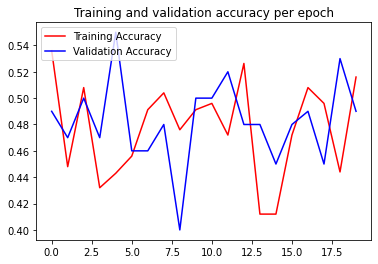

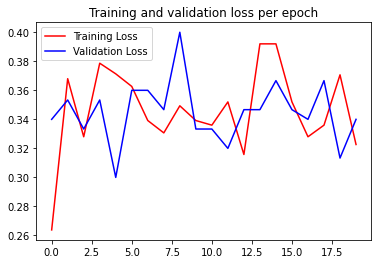

<Figure size 432x288 with 0 Axes>

In [105]:
'''
The basics of the code for creating graphs of the training and validation accuracy per epoch came from the following tutorial provided by Google:
 https://colab.research.google.com/github/lmoroney/mlday-tokyo/blob/master/Lab6-Cats-v-Dogs.ipynb#scrollTo=dn-6c02VmqiN
 I added to the code to make the graphs more descriptive.
'''

# Retrieve a list of list results on training and test datasets for each training epoch
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

# Get number of epochs
epochs= range(len(acc)) 

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy per epoch')
plt.legend(loc= 2)
plt.figure
plt.show()

print(" ")   #Inserting a space between plots

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label =  "Validation Loss")
plt.title('Training and validation loss per epoch')
plt.legend(loc= 0)
plt.figure()
plt.show()

# IMPORTANT NOTE: The code from here on out is the basically the same as the last three blocks above, the only difference is that now I will be fine tuning parameters and hyperparameters to increase the accuracy of my model (that is why I am not linking to references in the following code blocks because they have all been covered in the previous code blocks.

# Second Run: Adding two layers to neural net, decreasing epochs, increasing steps per epoch and validation steps

In [91]:
model = tf.keras.models.Sequential([
    #First convolution Layer
    tf.keras.layers.Conv2D(16, (3,3), activation= "relu", input_shape= (224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    #Second convolution layer
    tf.keras.layers.Conv2D(32, (3,3), activation= "relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    #Third convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation= "relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    #Fourth convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation= "relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    #Flattening to feed into DNN
    tf.keras.layers.Flatten(),

    #Hidden Layer with 512 neurons
    tf.keras.layers.Dense(512, activation= 'relu'),

    #
    tf.keras.layers.Dense(3, activation= 'softmax')

    ])

model.compile(loss= "mean_squared_error", optimizer= RMSprop(lr=0.001), metrics = ["acc"])

In [92]:
history = model.fit(train_data, 
                    epochs = 15, 
                    steps_per_epoch = 10, 
                    validation_data = valid_data, 
                    validation_steps = 3)

Epoch 1/15
10/10 [==============================] - 19s 2s/step - loss: 0.2385 - acc: 0.5160 - val_loss: 0.1113 - val_acc: 0.8533
Epoch 2/15
10/10 [==============================] - 17s 2s/step - loss: 0.3379 - acc: 0.4800 - val_loss: 0.3422 - val_acc: 0.4867
Epoch 3/15
10/10 [==============================] - 17s 2s/step - loss: 0.3467 - acc: 0.4800 - val_loss: 0.3467 - val_acc: 0.4800
Epoch 4/15
10/10 [==============================] - 16s 2s/step - loss: 0.3291 - acc: 0.5063 - val_loss: 0.3467 - val_acc: 0.4800
Epoch 5/15
10/10 [==============================] - 17s 2s/step - loss: 0.3667 - acc: 0.4500 - val_loss: 0.3378 - val_acc: 0.4933
Epoch 6/15
10/10 [==============================] - 17s 2s/step - loss: 0.3520 - acc: 0.4720 - val_loss: 0.3467 - val_acc: 0.4800
Epoch 7/15
10/10 [==============================] - 16s 2s/step - loss: 0.3017 - acc: 0.5418 - val_loss: 0.2810 - val_acc: 0.4933
Epoch 8/15
10/10 [==============================] - 17s 2s/step - loss: 0.1183 - acc: 0.80

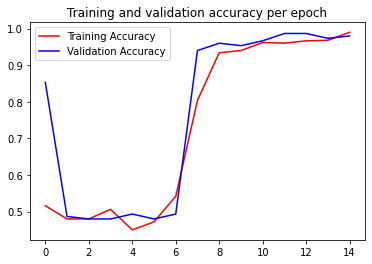

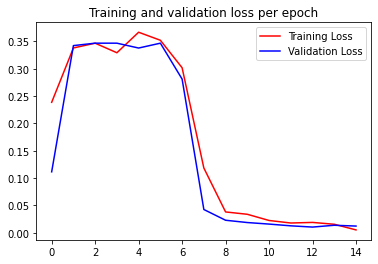

<Figure size 432x288 with 0 Axes>

In [99]:
# Retrieve a list of list results on training and test datasets for each training epoch
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

# Get number of epochs
epochs= range(len(acc)) 

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy per epoch')
plt.legend(loc= 2)
plt.figure
plt.show()

print(" ")   #Inserting a space between plots

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label =  "Validation Loss")
plt.title('Training and validation loss per epoch')
plt.legend(loc= 0)
plt.figure()
plt.show()

# Third Run: Regularizing neural net with dropout


In [100]:
model = tf.keras.models.Sequential([
    #First convolution Layer
    tf.keras.layers.Conv2D(16, (3,3), activation= "relu", input_shape= (224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    #Second convolution layer
    tf.keras.layers.Conv2D(32, (3,3), activation= "relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    #Third convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation= "relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    #Fourth convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation= "relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    #Flattening to feed into DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    #Hidden Layer with 512 neurons
    tf.keras.layers.Dense(512, activation= 'relu'),

    #Output Layer
    tf.keras.layers.Dense(3, activation= 'softmax')

    ])

model.compile(loss= "mean_squared_error", optimizer= RMSprop(lr=0.001), metrics = ["acc"])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [101]:
history = model.fit(train_data, 
                    epochs = 15, 
                    steps_per_epoch = 10, 
                    validation_data = valid_data, 
                    validation_steps = 3)

Epoch 1/15
10/10 [==============================] - 17s 2s/step - loss: 0.3425 - acc: 0.4372 - val_loss: 0.3422 - val_acc: 0.4867
Epoch 2/15
10/10 [==============================] - 17s 2s/step - loss: 0.3452 - acc: 0.4728 - val_loss: 0.3556 - val_acc: 0.4667
Epoch 3/15
10/10 [==============================] - 17s 2s/step - loss: 0.3587 - acc: 0.4620 - val_loss: 0.3600 - val_acc: 0.4600
Epoch 4/15
10/10 [==============================] - 17s 2s/step - loss: 0.3235 - acc: 0.4895 - val_loss: 0.2889 - val_acc: 0.4800
Epoch 5/15
10/10 [==============================] - 18s 2s/step - loss: 0.3147 - acc: 0.3940 - val_loss: 0.2774 - val_acc: 0.4733
Epoch 6/15
10/10 [==============================] - 17s 2s/step - loss: 0.2251 - acc: 0.5740 - val_loss: 0.1589 - val_acc: 0.9133
Epoch 7/15
10/10 [==============================] - 17s 2s/step - loss: 0.1516 - acc: 0.6960 - val_loss: 0.1744 - val_acc: 0.5467
Epoch 8/15
10/10 [==============================] - 17s 2s/step - loss: 0.0650 - acc: 0.88

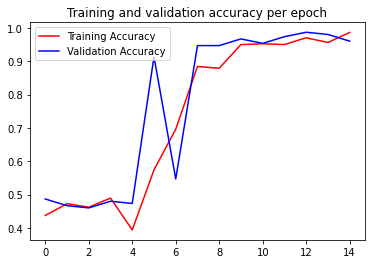

<Figure size 432x288 with 0 Axes>

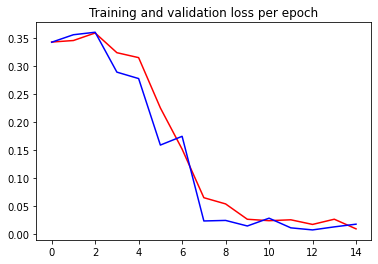

<Figure size 432x288 with 0 Axes>

In [102]:
# Retrieve a list of list results on training and test datasets for each training epoch
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

# Get number of epochs
epochs= range(len(acc)) 

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r',label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b',label =  "Validation Accuracy")
plt.title('Training and validation accuracy per epoch')
plt.legend(loc= 2)
plt.figure()
plt.show()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title('Training and validation loss per epoch')
plt.figure()
plt.show()